In [1]:
# Instaling nsepy - for share price data
# Installing ta - for technical indicators
#!pip install nsepy
#!pip install ta

In this notebook, i wil be predicting stock price by using various technical indicators.
1. **nsepy** library is used to extract share price history from National Stock Exchange's publicly available data.
>https://github.com/swapniljariwala/nsepy

2. **ta** i.e. technical analysis library is used to for feature engineering, calculating various technical indicators.
>https://github.com/bukosabino/ta

3. Altair, matplotlib and seaborn visualization libraries are used.

4. XGBRegressor is used for prediction.



In [2]:
import pandas as pd
import numpy as np
from nsepy import get_history
from datetime import date
from nsepy.history import get_price_list, get_indices_price_list
import datetime as dt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 10
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from ta.momentum import RSIIndicator, StochasticOscillator
from fastai.tabular.core import add_datepart
import seaborn as sns
import altair as alt

sns.set()
%matplotlib inline

#remove warnings
import warnings

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

nsepy's get_history() function seems to have some problem, it keeps on running without giving any output or just an empty dataframe as an output.
Luckily though, using get_price_list()  first seems to establish connection with the nse website and then get_history() works fine.

In [3]:
data = pd.read_csv("./AAPL_5y_1d.csv")

In [4]:
data.tail()

,Date,Open,High,Low,Close,Volume
1253,2022-08-12,169.820007,172.169998,169.399994,172.100006,67946400
1254,2022-08-15,171.520004,173.389999,171.350006,173.190002,54091700
1255,2022-08-16,172.779999,173.710007,171.660004,173.029999,56377100
1256,2022-08-17,172.770004,176.149994,172.570007,174.550003,79542000
1257,2022-08-18,173.750000,174.899994,173.119995,174.149994,62214200


In [5]:
data_new = data.drop(['Volume'], axis=1)

In [6]:
data_new.reset_index(inplace=True)

In [7]:
data_new.head()

,index,Date,Open,High,Low,Close
0,0,2017-08-21,37.369450,37.461983,36.802383,37.300644
1,1,2017-08-22,37.542652,37.962615,37.492828,37.910416
2,2,2017-08-23,37.741957,38.074128,37.696876,37.957867
3,3,2017-08-24,38.064636,38.138191,37.618578,37.789410
4,4,2017-08-25,37.879574,38.095487,37.789415,37.929401


In [8]:
alt.Chart(data_new).mark_line(color='blue').encode(
    x='Date',
    y='Close'
).properties(
    height=400,
    width=1000
)


alt.Chart(...)

# Feature Engineering


 fastai is used to extract datepart features from date


 **Simple Moving Average** - *A simple moving average (SMA) is an arithmetic moving average calculated by adding recent prices ( number of recent pr ices can be chose by parameter window) and then dividing that by the number of time periods in the calculation average.*


 **Exponential Moving Average** - *An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. It also takes window as a parameter.*


 **Relative Strength Index** - *The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.*
>https://www.investopedia.com/terms/r/rsi.asp

 **MACD** - *Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.*
>https://www.investopedia.com/terms/m/macd.asp

 **Stochastic Oscillator** - *A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0-100 bounded range of values.*
>https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [9]:
add_datepart(data_new, 'Date', drop=False)
data_new.drop('Elapsed', axis=1, inplace=True)  # not required for the model


In [10]:
def feature_calculator(share):
    share['EMA_9'] = share['Close'].ewm(9).mean()  # exponential moving average of window 9
    share['SMA_5'] = share['Close'].rolling(5).mean()  # moving average of window 5
    share['SMA_10'] = share['Close'].rolling(10).mean()  # moving average of window 10
    share['SMA_15'] = share['Close'].rolling(15).mean()  # moving average of window 15
    share['SMA_20'] = share['Close'].rolling(20).mean()  # moving average of window 20
    share['SMA_25'] = share['Close'].rolling(25).mean()  # moving average of window 25
    share['SMA_30'] = share['Close'].rolling(30).mean()  # moving average of window 30
    ema_12 = pd.Series(share['Close'].ewm(span=12, min_periods=12).mean())
    ema_26 = pd.Series(share['Close'].ewm(span=26, min_periods=26).mean())
    share['MACD'] = pd.Series(ema_12 - ema_26)  # calculates Moving Average Convergence Divergence
    share['RSI'] = RSIIndicator(share['Close']).rsi()  # calculates Relative Strength Index
    share['Stochastic'] = StochasticOscillator(share['High'], share['Low'],
                                               share['Close']).stoch()  # Calculates Stochastic Oscillator
    pass

In [11]:
feature_calculator(data_new)

In [12]:
def label_encode(share):
    le = LabelEncoder()
    share['Is_month_end'] = le.fit_transform(share['Is_month_end'])
    share['Is_month_start'] = le.fit_transform(share['Is_month_start'])
    share['Is_quarter_end'] = le.fit_transform(share['Is_quarter_end'])
    share['Is_quarter_start'] = le.fit_transform(share['Is_quarter_start'])
    share['Is_year_end'] = le.fit_transform(share['Is_year_end'])
    share['Is_year_start'] = le.fit_transform(share['Is_year_start'])
    pass

In [13]:
label_encode(data_new)

In [14]:
data_new.head(40)

,index,Date,Open,High,Low,Close,Year,Month,Week,Day,...,EMA_9,SMA_5,SMA_10,SMA_15,SMA_20,SMA_25,SMA_30,MACD,RSI,Stochastic
0,0,2017-08-21,37.369450,37.461983,36.802383,37.300644,2017,8,34,21,...,37.300644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2017-08-22,37.542652,37.962615,37.492828,37.910416,2017,8,34,22,...,37.621576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2017-08-23,37.741957,38.074128,37.696876,37.957867,2017,8,34,23,...,37.745669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2017-08-24,38.064636,38.138191,37.618578,37.789410,2017,8,34,24,...,37.758388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2017-08-25,37.879574,38.095487,37.789415,37.929401,2017,8,34,25,...,37.800148,37.777547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2017-08-28,37.995829,38.437145,37.946002,38.311394,2017,8,35,28,...,37.909259,37.979697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2017-08-29,37.986336,38.702877,37.962607,38.653053,2017,8,35,29,...,38.051829,38.128225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2017-08-30,38.864227,38.885580,38.581879,38.757458,2017,8,35,30,...,38.175725,38.288143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2017-08-31,38.826262,39.035058,38.788299,38.911678,2017,8,35,31,...,38.295865,38.512597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2017-09-01,39.101499,39.134717,38.823898,38.923550,2017,9,35,1,...,38.392236,38.711427,38.244487,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Dropping rows with Na values
data_new = data_new.iloc[33:]

In [16]:
data_new.reset_index(drop=True, inplace=True)

In [17]:
data_new.head()

,index,Date,Open,High,Low,Close,Year,Month,Week,Day,...,EMA_9,SMA_5,SMA_10,SMA_15,SMA_20,SMA_25,SMA_30,MACD,RSI,Stochastic
0,33,2017-10-06,36.769163,36.892543,36.671883,36.847462,2017,10,40,6,...,36.887373,36.655753,36.486343,36.642308,36.974400,37.247305,37.458187,-0.281570,46.985447,57.869626
1,34,2017-10-09,36.968476,37.186761,36.892553,36.975594,2017,10,41,9,...,36.896422,36.752084,36.611857,36.597544,36.907255,37.169387,37.426393,-0.240866,48.944396,73.406803
2,35,2017-10-10,37.027786,37.488083,36.800012,36.989822,2017,10,41,10,...,36.905977,36.819468,36.677343,36.552779,36.848413,37.110734,37.382341,-0.205183,49.169019,76.244245
3,36,2017-10-11,37.006424,37.246062,36.954225,37.144039,2017,10,41,11,...,36.930276,36.965147,36.732389,36.560371,36.811636,37.059864,37.332040,-0.163257,51.651794,83.596892
4,37,2017-10-12,37.096591,37.338600,36.949483,37.013546,2017,10,41,12,...,36.938758,36.994093,36.796925,36.601654,36.784588,37.009943,37.273910,-0.138470,49.450780,77.375324


In [18]:
data_new.drop(['Year', 'High', 'Low', 'Open', 'Date', 'index'], inplace=True, axis=1)

In [19]:
data_new.head()

,Close,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,...,EMA_9,SMA_5,SMA_10,SMA_15,SMA_20,SMA_25,SMA_30,MACD,RSI,Stochastic
0,36.847462,10,40,6,4,279,0,0,0,0,...,36.887373,36.655753,36.486343,36.642308,36.974400,37.247305,37.458187,-0.281570,46.985447,57.869626
1,36.975594,10,41,9,0,282,0,0,0,0,...,36.896422,36.752084,36.611857,36.597544,36.907255,37.169387,37.426393,-0.240866,48.944396,73.406803
2,36.989822,10,41,10,1,283,0,0,0,0,...,36.905977,36.819468,36.677343,36.552779,36.848413,37.110734,37.382341,-0.205183,49.169019,76.244245
3,37.144039,10,41,11,2,284,0,0,0,0,...,36.930276,36.965147,36.732389,36.560371,36.811636,37.059864,37.332040,-0.163257,51.651794,83.596892
4,37.013546,10,41,12,3,285,0,0,0,0,...,36.938758,36.994093,36.796925,36.601654,36.784588,37.009943,37.273910,-0.138470,49.450780,77.375324


In [20]:
data_new.columns

Index(['Close', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'EMA_9', 'SMA_5', 'SMA_10', 'SMA_15',
       'SMA_20', 'SMA_25', 'SMA_30', 'MACD', 'RSI', 'Stochastic'],
      dtype='object')

In [21]:
# Shifting the features a row up
data_new[['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15',
          'SMA_20', 'SMA_25', 'SMA_30', 'MACD', 'RSI', 'Stochastic']] = data_new[['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15',
                                                                                  'SMA_20', 'SMA_25', 'SMA_30', 'MACD',
                                                                                  'RSI', 'Stochastic']].shift(-1)

In [22]:
data_new.head()

,Close,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,...,EMA_9,SMA_5,SMA_10,SMA_15,SMA_20,SMA_25,SMA_30,MACD,RSI,Stochastic
0,36.847462,10,40,6,4,279,0,0,0,0,...,36.896422,36.752084,36.611857,36.597544,36.907255,37.169387,37.426393,-0.240866,48.944396,73.406803
1,36.975594,10,41,9,0,282,0,0,0,0,...,36.905977,36.819468,36.677343,36.552779,36.848413,37.110734,37.382341,-0.205183,49.169019,76.244245
2,36.989822,10,41,10,1,283,0,0,0,0,...,36.930276,36.965147,36.732389,36.560371,36.811636,37.059864,37.332040,-0.163257,51.651794,83.596892
3,37.144039,10,41,11,2,284,0,0,0,0,...,36.938758,36.994093,36.796925,36.601654,36.784588,37.009943,37.273910,-0.138470,49.450780,77.375324
4,37.013546,10,41,12,3,285,0,0,0,0,...,36.970243,37.074287,36.865020,36.682324,36.750303,36.994378,37.218469,-0.099600,53.307729,83.993149


In [23]:
def datetime_to_float(d):
    epoch = dt.datetime.utcfromtimestamp(0)
    total_seconds = (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

In [24]:
data_new.head()

,Close,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,...,EMA_9,SMA_5,SMA_10,SMA_15,SMA_20,SMA_25,SMA_30,MACD,RSI,Stochastic
0,36.847462,10,40,6,4,279,0,0,0,0,...,36.896422,36.752084,36.611857,36.597544,36.907255,37.169387,37.426393,-0.240866,48.944396,73.406803
1,36.975594,10,41,9,0,282,0,0,0,0,...,36.905977,36.819468,36.677343,36.552779,36.848413,37.110734,37.382341,-0.205183,49.169019,76.244245
2,36.989822,10,41,10,1,283,0,0,0,0,...,36.930276,36.965147,36.732389,36.560371,36.811636,37.059864,37.332040,-0.163257,51.651794,83.596892
3,37.144039,10,41,11,2,284,0,0,0,0,...,36.938758,36.994093,36.796925,36.601654,36.784588,37.009943,37.273910,-0.138470,49.450780,77.375324
4,37.013546,10,41,12,3,285,0,0,0,0,...,36.970243,37.074287,36.865020,36.682324,36.750303,36.994378,37.218469,-0.099600,53.307729,83.993149


# Train test split

In [25]:
# Splitting the dataset into 70% training, 15% validation and 15% test
# train test split indexes
test_size = 0.15
valid_size = 0.15

test_split_idx = int(data_new.shape[0] * (1 - test_size))
valid_split_idx = int(data_new.shape[0] * (1 - (valid_size + test_size)))

#train test split tcs

train = data_new.loc[:valid_split_idx]
valid = data_new.loc[valid_split_idx + 1:test_split_idx]
test = data_new.loc[test_split_idx + 1:]

In [26]:
y_train = train['Close']
X_train = train.drop(['Close'], 1)

y_valid = valid['Close']
X_valid = valid.drop(['Close'], 1)

y_test = test['Close']
X_test = test.drop(['Close'], 1)

# XGBoost Model


In [27]:
parameters = {
    'n_estimators': [500, 600],
    'learning_rate': [0.1],
    'max_depth': [8, 12, 15],
    'gamma': [0.005, 0.01, ],
    'random_state': [42],
    'min_child_weight': [4, 3],
    'subsample': [0.8, 1],
    'colsample_bytree': [1],
    'colsample_bylevel': [1]
}
kfold = KFold(5)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = XGBRegressor(objective='reg:squarederror', n_jobs=-1)
clf = GridSearchCV(model, parameters, cv=kfold, scoring='neg_mean_absolute_error', verbose=0)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.005, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 600, 'random_state': 42, 'subsample': 0.8}
Best validation score = -8.193553598108995


In [28]:
model = XGBRegressor(**clf.best_params_, objective='reg:squarederror', n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

23.897093725986167

# Handtuning the hyperparameters

In [29]:
params = {'colsample_bylevel': 1,
          'colsample_bytree': 0.6,
          'gamma': 0.005,
          'learning_rate': 0.07,
          'max_depth': 10,
          'min_child_weight': 1,
          'n_estimators': 170,
          'random_state': 42,
          'subsample': 0.6}
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [30]:
xgb = XGBRegressor(**params, objective='reg:squarederror', n_jobs=-1)
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred = xgb.predict(X_test)
mean_absolute_error(y_test, y_pred)

27.976570358693273

The mean absolute error has reduced from 35.1153 to 28.9871

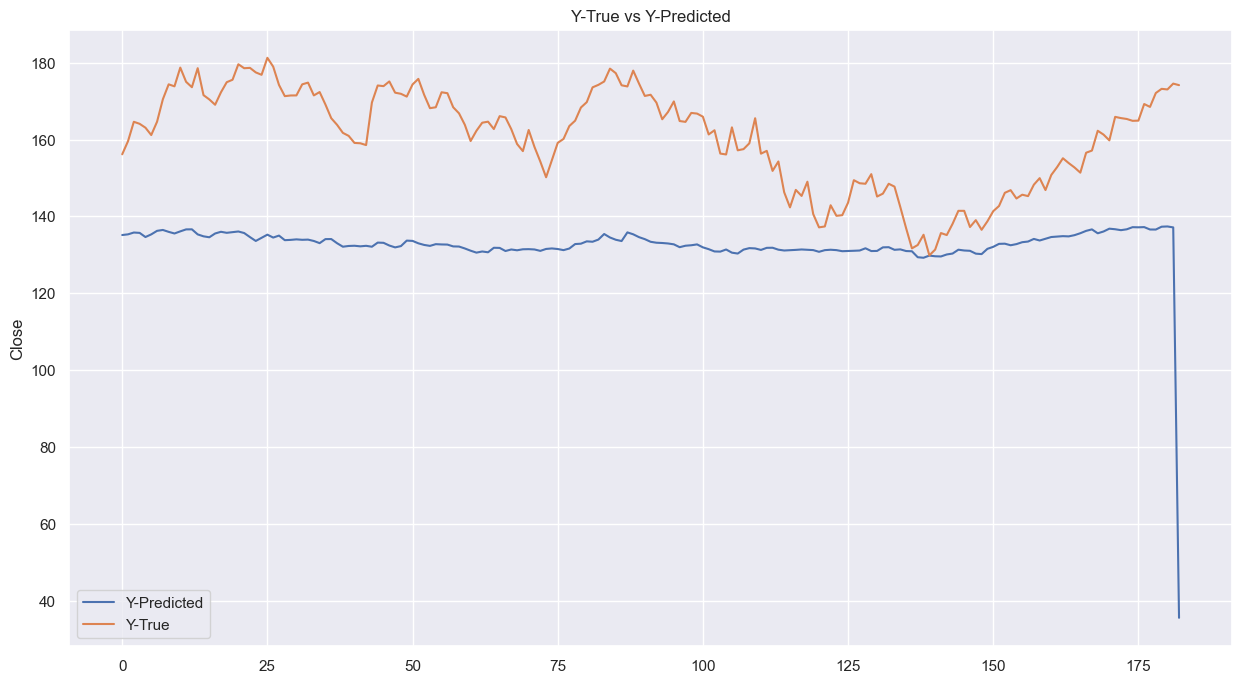

In [31]:
plt.figure(figsize=(15, 8))
sns.lineplot(y=y_pred, x=np.arange(len(y_pred)))
sns.lineplot(y=y_test, x=np.arange(len(y_test)))
plt.legend(['Y-Predicted', 'Y-True'])
plt.title('Y-True vs Y-Predicted')
plt.show()